In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import ordinal_encode

from joblib import Memory
from lime.lime_tabular import LimeTabularExplainer
import shap
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    RepeatedKFold,
    TimeSeriesSplit,
)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from skrub import TableVectorizer
import warnings

pd.options.display.max_columns = 200

warnings.filterwarnings("ignore", category=RuntimeWarning)

/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Project Description  

**Goal:**  
The goal of this project is to apply most of the techniques presented during this course on a dataset provided by the instructor and available on Slack.  

**Groups:**  
Students have to work by group of six people. The groups have to be set by the Student Representatives.  

**Delivery:**  
Each group must deliver a computer code (Python, R, etc.) and a slide presentation, which both have to be sent by email to the instructor before **Monday September 29, 9:40 AM**.  

**Presentation:**  
Each group has to make a presentation on campus to a jury on **Wednesday September 29 between 9:40 AM and 5:50 PM** (exact time for each team TBC).  
- **Presentation:** 15 minutes  
- **Q&A:** 10 minutes  

**Dataset:**  
The dataset can be downloaded from Slack (`dataproject2025.xlsx`).  
The dataset must be deleted at the end of the project.  


### Preliminary work: EDA on eda_surrogate notebook

In [2]:
PATH = "./dataproject2025.csv"
df = pd.read_csv(PATH, index_col=0)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

Shape: (1086236, 38)
Columns: ['issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']


,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,fico_range_high,funded_amnt,grade,home_ownership,inq_last_6mths,int_rate,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_bc_tl,num_il_tl,num_rev_accts,open_acc,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,759.0,4800.0,B,MORTGAGE,2.0,10.99,220.0,25.0,25.0,0.0,25.0,2.0,4.0,1.0,7.0,3.0,0.0,0.0,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,734.0,27050.0,B,OWN,0.0,10.99,326.0,16.0,6.0,4.0,16.0,2.0,8.0,8.0,15.0,14.0,0.0,0.0,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,sales manager,749.0,28000.0,A,MORTGAGE,1.0,7.62,229.0,5.0,2.0,5.0,5.0,4.0,8.0,11.0,15.0,15.0,0.0,0.0,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,other,719.0,12000.0,B,MORTGAGE,1.0,11.99,193.0,4.0,4.0,3.0,85.0,3.0,4.0,8.0,8.0,9.0,0.0,0.0,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,other,669.0,27600.0,D,MORTGAGE,1.0,19.97,294.0,4.0,4.0,4.0,4.0,5.0,11.0,4.0,16.0,10.0,0.0,0.0,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


### Step 1: Default probability analysis

Use the estimated default probability (DP) provided in the dataset.  
Implement one or two surrogate model(s) to interpret the unknown model used to generate DP.  


In [3]:
# to cache the transformed variable
memory = Memory(location=".cache_sklearn", verbose=0)

X = df.drop(columns=["Predicted probabilities", "Predictions", "target"])
y = df["Predicted probabilities"]

model = make_pipeline(
    TableVectorizer(numeric=StandardScaler(), n_jobs=1),
    LinearRegression(),
    memory=memory,
)

cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=42)

cv_model = cross_validate(model, X, y, cv=cv, return_estimator=True, n_jobs=4)


In [4]:
feature_names = cv_model["estimator"][1][0].get_feature_names_out()

coefs = pd.DataFrame(
    [cv_model["estimator"][i][-1].coef_ for i in range(len(cv_model["estimator"]))],
    columns=feature_names,
)

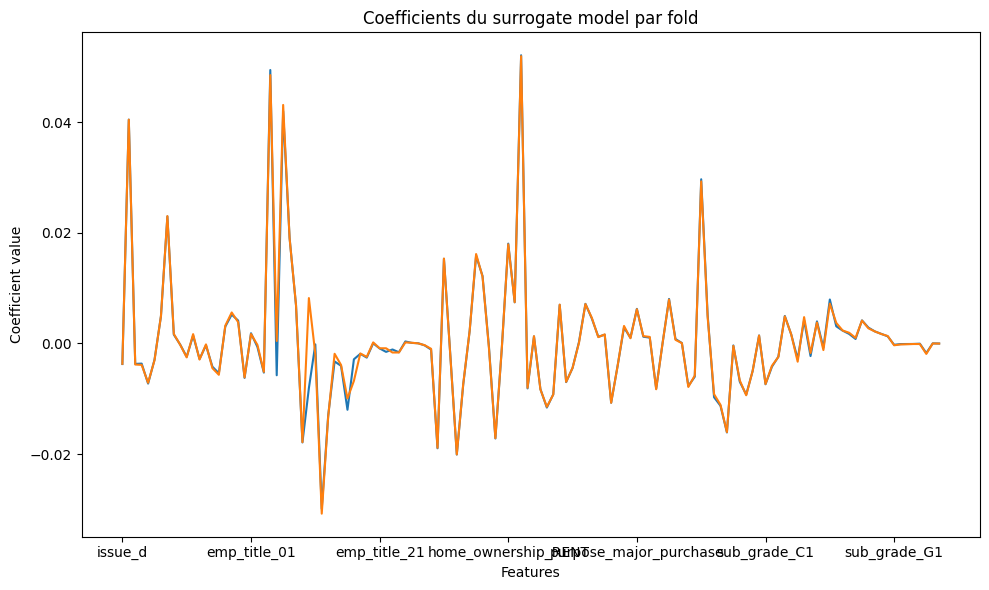

In [5]:
coefs.T.plot(legend=False, figsize=(10, 6))
plt.title("Coefficients du surrogate model par fold")
plt.xlabel("Features")
plt.ylabel("Coefficient value")
plt.tight_layout()
plt.show()

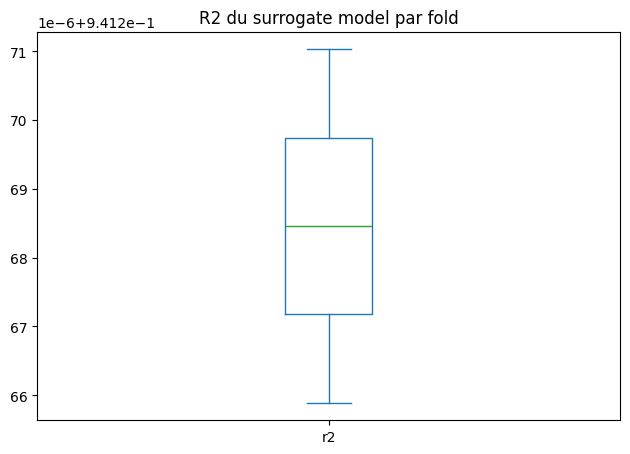

In [6]:
results = pd.DataFrame(cv_model["test_score"], columns=["r2"])

results.plot(kind="box", legend=False)
plt.title("R2 du surrogate model par fold")
plt.tight_layout()
plt.show()

### Step 2: Our black-box model

Estimate your own black-box machine learning model to forecast default.  
Each model is specific to a group of students and cannot be developed in collaboration with another group.  


In [7]:
df_blackbox = df.dropna(subset=["Predicted probabilities"])
df_blackbox = df_blackbox.dropna()

# Comme au dessus, on trie par dates
df_blackbox = df_blackbox.sort_values("issue_d")

y = df_blackbox["target"]
# ce qui change par rapport à notre surrogate, puisqu'on ne prédit plus la prédiction de la target, mais la target directement
X = df_blackbox.drop(columns=["Predicted probabilities", "Predictions", "target"])

split_idx = int(len(df_blackbox) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

ord_transformer = FunctionTransformer(ordinal_encode, validate=False)

pipe = Pipeline(
    [
        ("ord", ord_transformer),
        ("vec", TableVectorizer()),
        ("clf", HistGradientBoostingClassifier()),
    ]
)
pipe.fit(X_train, y_train)

,steps,"[('ord', ...), ('vec', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function ord...t 0x11667ede0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [8]:
proba = pipe.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, pred) * 100:.2f}%")
print(f"AUC: {roc_auc_score(y_test, proba):.4f}")

Accuracy: 76.55%
AUC: 0.7094


### Step 3: Stability

Analyze the forecasting performance and structural stability of your own model.  


In [9]:
tscv = TimeSeriesSplit(n_splits=5)

# Le TimeSeriesSplit nous permet, ici aussi, d'assurer une forme de cohérence passé vs futur
auc_scores = cross_val_score(pipe, X, y, cv=tscv, scoring="roc_auc", n_jobs=-1)
print("AUC per fold:", np.round(auc_scores, 4))
print(f"Mean AUC: {auc_scores.mean():.4f} ± {auc_scores.std(ddof=1):.4f}")

# Accuracy + AUC avec cross_validate
scores = cross_validate(
    pipe,
    X,
    y,
    cv=tscv,
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    return_train_score=False,
    n_jobs=-1,
)

print("\nAccuracy per fold:", np.round(scores["test_Accuracy"], 4))
print(
    f"Mean Accuracy: {scores['test_Accuracy'].mean():.4f} ± {scores['test_Accuracy'].std(ddof=1):.4f}"
)

AUC per fold: [0.7032 0.726  0.7145 0.7186 0.7134]
Mean AUC: 0.7151 ± 0.0083

Accuracy per fold: [0.7908 0.7902 0.7965 0.7935 0.7682]
Mean Accuracy: 0.7879 ± 0.0112


### Step 4: Global interpretability.  
Implement one or two surrogate model(s) to interpret your own model. Compare the results provided in Steps 1 and 4.  


First, we predict all the data to obtain all the model’s predictions and to be able to evaluate said model using the surrogate

In [10]:
pipe.fit(X, y)
proba_blackbox = pipe.predict_proba(X)[:, 1]
pred_blackbox = (proba_blackbox >= 0.5).astype(int)

We will here sort our DataFrame by dates so that our train/test split reflects temporality (we want to predict future data with past data and not the opposite)

In [11]:
df_blackbox_clean = df.dropna(subset=["Predicted probabilities"])
df_blackbox_clean = df_blackbox_clean.dropna()

# Date sorting
df_blackbox = df_blackbox.sort_values("issue_d")

# Target for surrogate: black-box predictions
y = pred_blackbox
X = df_blackbox.drop(columns=["Predicted probabilities", "Predictions", "target"])

split_idx = int(len(df_blackbox) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Surrogate 1: shallow tree
tree = Pipeline(
    [
        ("ord", ord_transformer),
        ("vec", TableVectorizer()),
        ("reg", DecisionTreeRegressor(max_depth=8, random_state=42)),
    ]
)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Tree R2 (fidelity to our blackbox):", r2_score(y_test, pred_tree))

# Surrogate 2: linear regression
lin = Pipeline(
    [("ord", ord_transformer), ("vec", TableVectorizer()), ("reg", LinearRegression())]
)
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)
print("Linear R2 (fidelity to our blackbox):", r2_score(y_test, pred_lin))

Tree R2 (fidelity to our blackbox): -0.013528620984717188
Linear R2 (fidelity to our blackbox): -0.01147913932800293


The R2 indicate that our surrogates perform pretty bad when compared to our blackbox model

Let's try to do an interpretation analysis thanks to our surrogates for first conclusions:

In [12]:
tree = tree.named_steps["reg"]
rules = export_text(tree, feature_names=pipe[:-1].fit_transform(X_train).columns)
print(rules)

|--- issue_d <= 2014.50
|   |--- issue_d <= 2013.50
|   |   |--- mo_sin_rcnt_tl <= 155.50
|   |   |   |--- annual_inc <= 399500.00
|   |   |   |   |--- int_rate <= 6.02
|   |   |   |   |   |--- num_il_tl <= 24.00
|   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |--- num_il_tl >  24.00
|   |   |   |   |   |   |--- value: [1.00]
|   |   |   |   |--- int_rate >  6.02
|   |   |   |   |   |--- num_actv_bc_tl <= 16.50
|   |   |   |   |   |   |--- mo_sin_rcnt_rev_tl_op <= 142.50
|   |   |   |   |   |   |   |--- Pct_afro_american <= 0.41
|   |   |   |   |   |   |   |   |--- value: [0.01]
|   |   |   |   |   |   |   |--- Pct_afro_american >  0.41
|   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |--- mo_sin_rcnt_rev_tl_op >  142.50
|   |   |   |   |   |   |   |--- annual_inc <= 259000.00
|   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |--- annual_inc >  259000.00
|   |   |   |   |   |   |   |   |--- value: [1.00]
|   |   |   

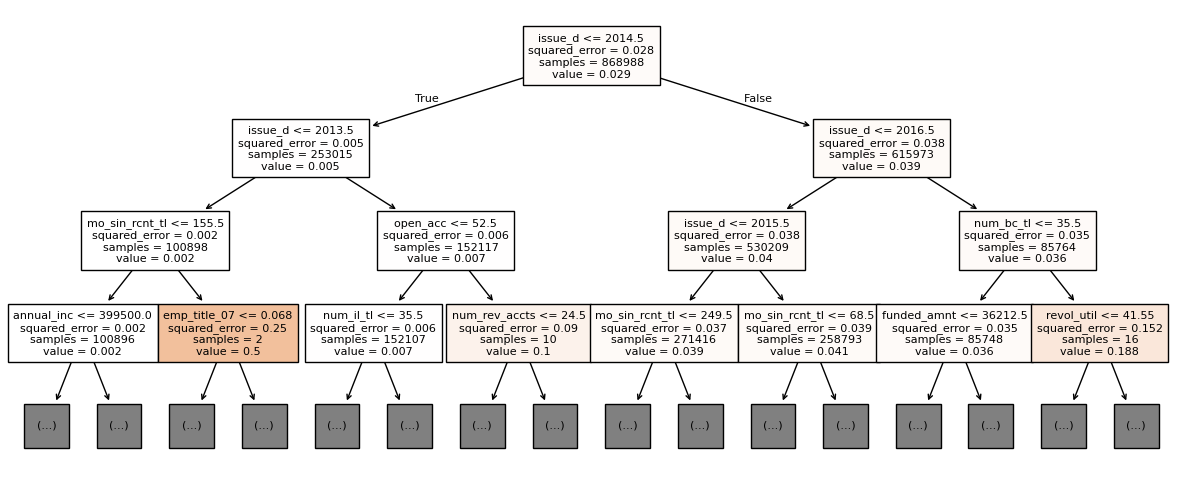

In [13]:
plt.figure(figsize=(15, 6))
plot_tree(
    tree,
    feature_names=pipe[:-1].fit_transform(X_train).columns,
    filled=True,
    max_depth=3,
    fontsize=8,
)
plt.show()

In [14]:
lin = lin.named_steps["reg"]

X_transformed = pipe[:-1].fit_transform(
    X_train
)  # pour transformer nos données avec l'encodage

coefs = pd.Series(lin.coef_, index=pd.DataFrame(X_transformed).columns)
coefs_sorted = coefs.sort_values(key=np.abs, ascending=False)
print(coefs_sorted.head(10))

funded_amnt            -1.443269e-07
avg_cur_bal            -6.212396e-08
bc_open_to_buy          2.780280e-08
annual_inc              1.972161e-08
revol_bal              -8.908932e-09
mo_sin_old_rev_tl_op   -1.367123e-10
zip_code               -8.595759e-11
bc_util                -8.000356e-11
revol_util             -7.979153e-11
mths_since_recent_bc   -4.797486e-11
dtype: float32


### Step 5: Global interpretability (PDP method).  
Implement the PDP method to interpret your own model. Compare the results provided in Steps 4 and 5.  

/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avo

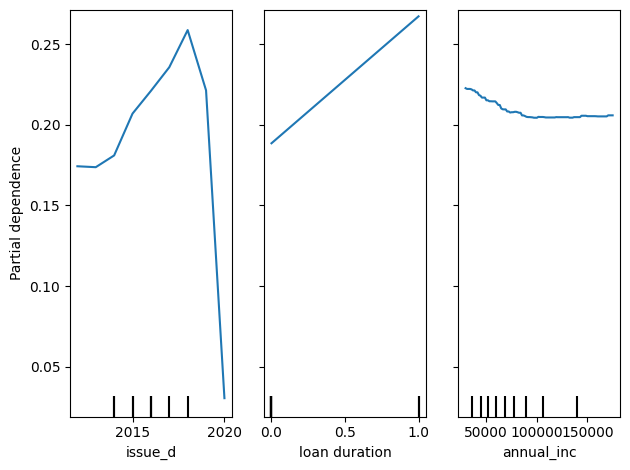

In [15]:
drop_cols = [
    c for c in ["target", "Predicted probabilities", "Predictions"] if c in df.columns
]
X_pdp = df.drop(columns=drop_cols)

X_pdp = ordinal_encode(X_pdp)
num_feats = X_pdp.select_dtypes(include="number").columns.tolist()
features = num_feats[:3] if len(num_feats) > 0 else X_pdp.columns.tolist()[:3]
PartialDependenceDisplay.from_estimator(
    pipe,
    X_pdp,
    features=features,
    response_method="predict_proba",
    kind="average",
    subsample=100,
    random_state=42,
)

plt.tight_layout()
plt.show()

### Step 6: Local interpretability (LIME / ICE).  
Implement the LIME and/or ICE methods to interpret your own model.  


/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avo

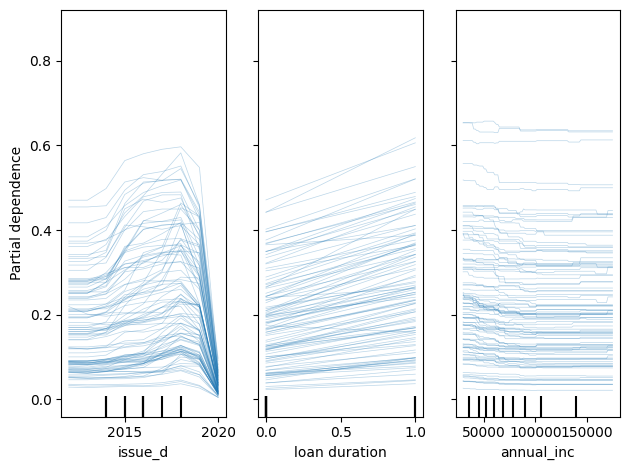

In [16]:
drop_cols = [
    c for c in ["target", "Predicted probabilities", "Predictions"] if c in df.columns
]
X_ice = df.drop(columns=drop_cols)

# ICE
X_ice = ordinal_encode(X_ice)
if "features" not in locals():
    _num = X_ice.select_dtypes(include="number").columns.tolist()
    features = _num[:2] if _num else X_ice.columns[:2]
PartialDependenceDisplay.from_estimator(
    pipe,
    X_ice,
    features=features,
    response_method="predict_proba",
    kind="individual",
    subsample=100,
    target=1,
)
plt.tight_layout()
plt.show()

/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/var/folders/mj/643xyq7n1y11ntfcc60cf3_00000gn/T/ipykernel_25618/1925732216.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


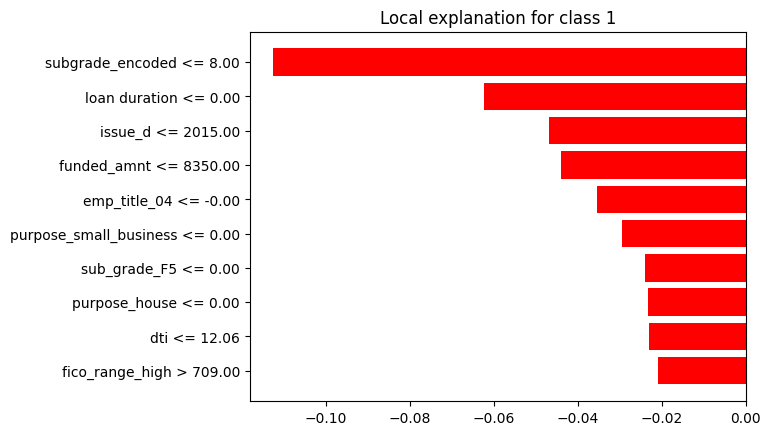

In [17]:
drop_cols = [
    c for c in ["target", "Predicted probabilities", "Predictions"] if c in df.columns
]
X_lime = df.drop(columns=drop_cols)
X_lime = ordinal_encode(X_lime)

# LIME
vec, clf = pipe.named_steps["vec"], pipe.named_steps["clf"]
Xt = vec.transform(X_lime)
if hasattr(Xt, "toarray"):
    Xt = Xt.toarray()
elif hasattr(Xt, "to_numpy"):
    Xt = Xt.to_numpy()
else:
    print("Warning: could not convert to array")
exp = LimeTabularExplainer(
    Xt, feature_names=vec.get_feature_names_out(), mode="classification"
)
fig = exp.explain_instance(Xt[0], clf.predict_proba).as_pyplot_figure()
fig.show()

### Step 7: Local interpretability (SHAP).  
Implement the SHAP method to interpret your own model. Compare the results provided in Steps 6 and 7.  



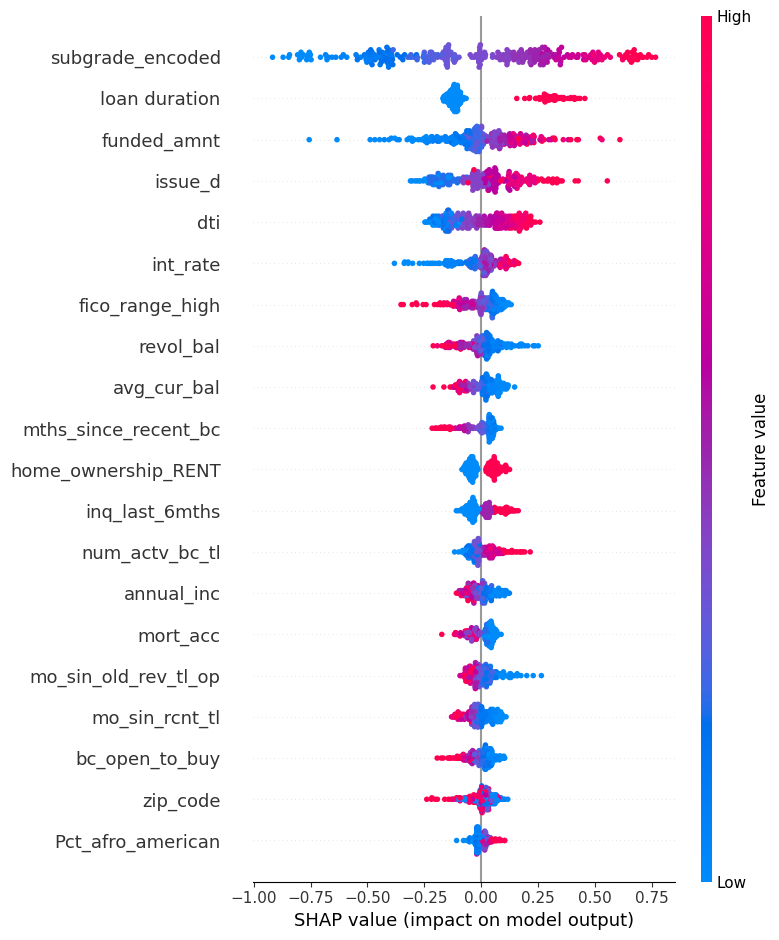

[(np.str_('subgrade_encoded'), np.float64(0.35188925120441594)), (np.str_('loan duration'), np.float64(0.17126927836379877)), (np.str_('funded_amnt'), np.float64(0.13345341275740397)), (np.str_('issue_d'), np.float64(0.12375846276675685)), (np.str_('dti'), np.float64(0.1141218288869036)), (np.str_('int_rate'), np.float64(0.06929576349146818)), (np.str_('fico_range_high'), np.float64(0.06355219005369264)), (np.str_('revol_bal'), np.float64(0.055419298666596645)), (np.str_('avg_cur_bal'), np.float64(0.05487885922411132)), (np.str_('mths_since_recent_bc'), np.float64(0.0507776795616594))]


In [18]:
drop_cols = [
    c for c in ["target", "Predicted probabilities", "Predictions"] if c in df.columns
]
X = df.drop(columns=drop_cols)
X = ordinal_encode(X)

vec, clf = pipe.named_steps["vec"], pipe.named_steps["clf"]
Xt = vec.transform(X)
if hasattr(Xt, "toarray"):
    Xt = Xt.toarray()
elif hasattr(Xt, "to_numpy"):
    Xt = Xt.to_numpy()
else:
    print("Warning: could not convert to array")

feat_names = vec.get_feature_names_out()
idx = np.random.RandomState(42).choice(
    Xt.shape[0], size=min(300, Xt.shape[0]), replace=False
)
explainer = shap.Explainer(clf, Xt[idx])
sv = explainer(Xt[idx])
shap.summary_plot(sv, Xt[idx], feature_names=feat_names, show=True)
vals = np.abs(sv.values).mean(0)
top = np.argsort(-vals)[:10]
print(list(zip(feat_names[top], vals[top])))

### Step 8: Performance interpretability (Permutation Importance).  
Implement the Permutation Importance method to identify the main drivers of the predictive performance of your model.  
Are the drivers of the performance metric (Step 8) similar to the drivers of the individual forecasts identified by SHAP (Step 7)?  


In [19]:
X_test = ordinal_encode(X_test)
r = permutation_importance(
    pipe, X_test, y_test, scoring="roc_auc", n_repeats=20, random_state=42, n_jobs=-1
)
idx = np.argsort(-r.importances_mean)
top_pi = [
    (X_test.columns[i], r.importances_mean[i], r.importances_std[i]) for i in idx[:10]
]
print("Permutation importance (top 10):", top_pi)
if "feat_names" in locals() and "vals" in locals():
    top_shap_idx = np.argsort(-vals)[:10]
    shap_top = list(zip(feat_names[top_shap_idx], vals[top_shap_idx]))
    print("SHAP (top 10):", shap_top)

/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Permutation importance (top 10): [('issue_d', np.float64(0.014002643716944485), np.float64(0.0005858118531502957)), ('funded_amnt', np.float64(0.0007239117120495852), np.float64(0.0012134392898709805)), ('bc_open_to_buy', np.float64(0.0006812577091275584), np.float64(0.000296781108616071)), ('num_il_tl', np.float64(0.0005770259607518813), np.float64(0.0002486777563372706)), ('zip_code', np.float64(0.0003785178427416269), np.float64(0.0002508490420223193)), ('avg_cur_bal', np.float64(0.0003584880495451803), np.float64(0.00023527903576811814)), ('annual_inc', np.float64(0.00023721875880470812), np.float64(0.00024815136894572993)), ('revol_util', np.float64(0.00019090990226840464), np.float64(5.0898955337507114e-05)), ('bc_util', np.float64(0.0001567217587762626), np.float64(0.00015295918228660956)), ('emp_title', np.float64(0.00013775028451710192), np.float64(0.00028864166960905973))]
SHAP (top 10): [(np.str_('subgrade_encoded'), np.float64(0.35188925120441594)), (np.str_('loan duration'

/Users/paul/code/hec/02-interpretability-stability-and-algorithmic-fairness/fairness_project/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


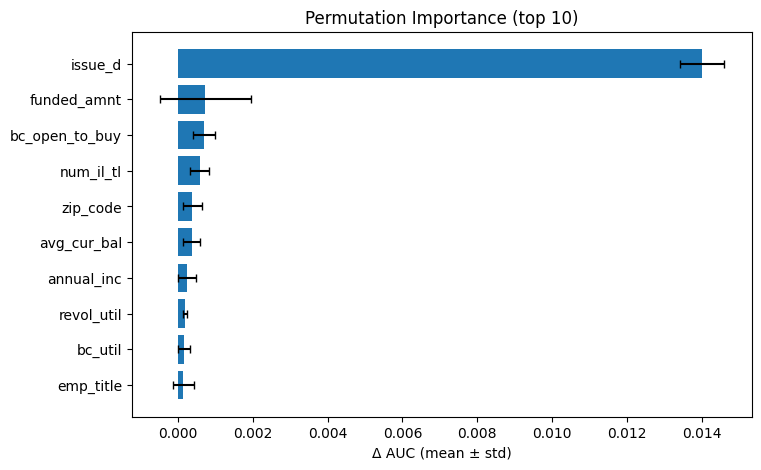

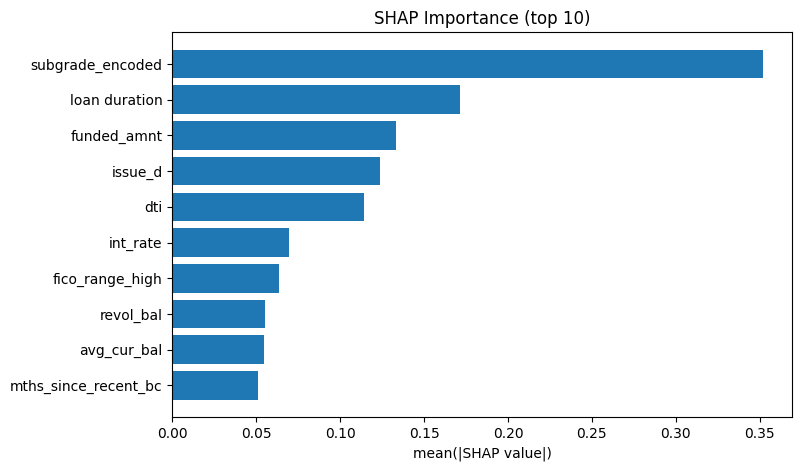

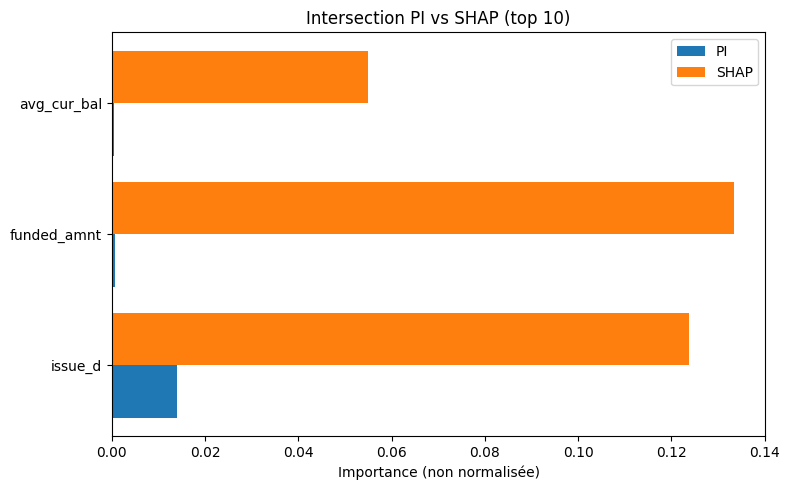

In [20]:
X_test = ordinal_encode(X_test)
r = permutation_importance(
    pipe, X_test, y_test, scoring="roc_auc", n_repeats=20, random_state=42, n_jobs=-1
)
idx = np.argsort(-r.importances_mean)

# Top PI
top_pi = [
    (X_test.columns[i], r.importances_mean[i], r.importances_std[i]) for i in idx[:10]
]
df_pi = pd.DataFrame(top_pi, columns=["feature", "pi_mean", "pi_std"])

# Plot PI
plt.figure(figsize=(8, 5))
plt.barh(df_pi["feature"], df_pi["pi_mean"], xerr=df_pi["pi_std"], capsize=3)
plt.gca().invert_yaxis()
plt.title("Permutation Importance (top 10)")
plt.xlabel("Δ AUC (mean ± std)")
plt.show()

# Top SHAP
if "feat_names" in locals() and "vals" in locals():
    top_shap_idx = np.argsort(-vals)[:10]
    shap_top = list(zip(feat_names[top_shap_idx], vals[top_shap_idx]))
    df_shap = pd.DataFrame(shap_top, columns=["feature", "shap_importance"])

    # Plot SHAP
    plt.figure(figsize=(8, 5))
    plt.barh(df_shap["feature"], df_shap["shap_importance"])
    plt.gca().invert_yaxis()
    plt.title("SHAP Importance (top 10)")
    plt.xlabel("mean(|SHAP value|)")
    plt.show()

    # Intersection des features présentes dans les deux
    df_inter = pd.merge(df_pi, df_shap, on="feature", how="inner")
    if not df_inter.empty:
        plt.figure(figsize=(8, 5))
        width = 0.4
        y = np.arange(len(df_inter))
        plt.barh(y - width / 2, df_inter["pi_mean"], height=width, label="PI")
        plt.barh(y + width / 2, df_inter["shap_importance"], height=width, label="SHAP")
        plt.yticks(y, df_inter["feature"])
        plt.title("Intersection PI vs SHAP (top 10)")
        plt.xlabel("Importance (non normalisée)")
        plt.legend()
        plt.tight_layout()
        plt.show()

### Step 9: Fairness

Assess the fairness of your own model with respect to the ethnicity of the borrower (protected attribute).  
Discuss your results.

In [21]:
prot_col = "Pct_afro_american"
s_test = df.loc[X_test.index, prot_col]

p = pipe.predict_proba(X_test)[:, 1]
y_true = y_test
y_pred = (p >= 0.5).astype(int)

ref = s_test.value_counts().idxmax()
rows = []

for g in s_test.unique():
    m = (s_test == g).values
    yt, yp, pp = y_true[m], y_pred[m], p[m]
    pos, neg = (yt == 1).sum(), (yt == 0).sum()

    tpr = (((yp == 1) & (yt == 1)).sum() / pos) if pos else np.nan
    fpr = (((yp == 1) & (yt == 0)).sum() / neg) if neg else np.nan

    sel = yp.mean() if len(yp) else np.nan
    aucg = roc_auc_score(yt, pp) if pos and neg else np.nan
    rows.append(
        {
            "group": g,
            "n": len(yt),
            "selection_rate": sel,
            "TPR": tpr,
            "FPR": fpr,
            "AUC": aucg,
        }
    )
    
grp = pd.DataFrame(rows).sort_values("n", ascending=False)
print(grp)
ref_row = grp[grp["group"] == ref].iloc[0]
spd = (grp["selection_rate"] - ref_row["selection_rate"]).to_dict()
di = (
    (grp["selection_rate"] / ref_row["selection_rate"])
    .replace([np.inf, -np.inf], np.nan)
    .to_dict()
)
eo = grp.apply(
    lambda r: max(abs(r["TPR"] - ref_row["TPR"]), abs(r["FPR"] - ref_row["FPR"])),
    axis=1,
).to_dict()
print("reference_group:", ref)
print("statistical_parity_diff:", spd)
print("disparate_impact:", di)
print("equalized_odds_diff:", eo)

         group     n  selection_rate       TPR       FPR       AUC
31    7.542862  2360        0.034322  0.023438  0.034946  0.470892
121  11.488900  2333        0.038577  0.034965  0.038813  0.515369
48   31.308409  2241        0.103525  0.131250  0.101394  0.565831
94   33.058290  2056        0.048638  0.055556  0.048255  0.537327
124  16.950991  1924        0.082121  0.102804  0.080903  0.493177
..         ...   ...             ...       ...       ...       ...
723   1.052146     3        0.000000  0.000000  0.000000  1.000000
827   1.292498     2        0.000000       NaN  0.000000       NaN
858   0.562195     2        0.000000       NaN  0.000000       NaN
837   3.888419     2        0.000000       NaN  0.000000       NaN
838   0.117220     1        0.000000       NaN  0.000000       NaN

[860 rows x 6 columns]
reference_group: 7.542862052159502
statistical_parity_diff: {31: 0.0, 121: 0.0042549056644895986, 48: 0.06920317806064182, 94: 0.01431609839741476, 124: 0.04779854822227704

### Step 10: Fairness PDP

Implement a FPDP using a fairness measure.  
Discuss your results.  

                  bin  spd_max_abs
0  (2016.999, 2018.0]     0.560000
1    (2018.0, 2020.0]     0.330556


/var/folders/mj/643xyq7n1y11ntfcc60cf3_00000gn/T/ipykernel_25618/355403357.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in t.groupby("bin"):


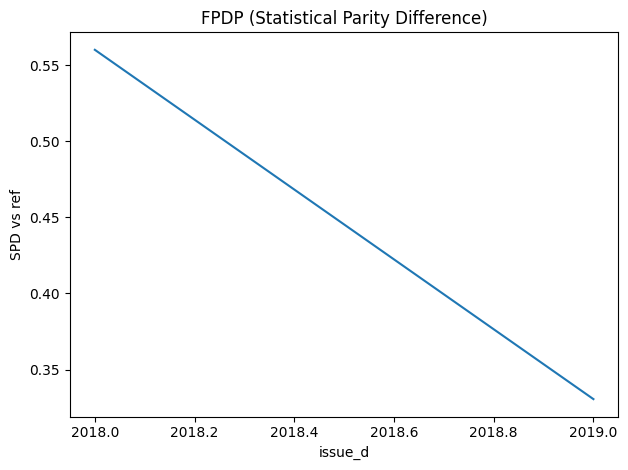

In [22]:
prot_col = "Pct_afro_american"
if "features" not in locals():
    _num = X.select_dtypes(include="number").columns.tolist()
    features = _num[:1] if _num else X.columns[:1]
s = df.loc[X_test.index, prot_col]
p = pipe.predict_proba(X_test)[:, 1]
yp = (p >= 0.5).astype(int)
ref = s.value_counts().idxmax()


def fpdp_spd(feature, n_bins=10, min_n=30):
    v = X_test[feature]
    bins = pd.qcut(v, q=min(n_bins, max(2, v.nunique())), duplicates="drop")
    t = pd.DataFrame({"bin": bins, "pred": yp, "group": s, "val": v})
    rows = []
    for b, g in t.groupby("bin"):
        if len(g) < min_n:
            continue
        sel = g.groupby("group")["pred"].mean()
        spd = sel - sel.get(ref, np.nan)
        rows.append(
            {
                "bin": str(b),
                "center": g["val"].median(),
                "spd_max_abs": spd.abs().max(),
                "spd": spd.to_dict(),
            }
        )
    return pd.DataFrame(rows).sort_values("center")


res = fpdp_spd(features[0])
print(res[["bin", "spd_max_abs"]].head())
plt.figure()
plt.plot(res["center"], res["spd_max_abs"])
plt.xlabel(features[0])
plt.ylabel("SPD vs ref")
plt.title("FPDP (Statistical Parity Difference)")
plt.tight_layout()
plt.show()